## **패키지 설치하기(Colab 기준, LMS는 별도.)**

In [2]:
!pip install sentencepiece

In [3]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 39.8 MB/s eta 0:00:00


### **라이브러리 확인해보기**

In [13]:
# 라이브러리 불러오기
import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **데이터 업로드하기**

### **학습 데이터 불러오기**

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [7]:
# 학습 데이터셋 불러오기
# 경로를 적절히 수정해주세요.
train_data_path ="/content/drive/MyDrive/07. GoData/20. DKTC/conversations.csv"
train_data = pd.read_csv(train_data_path)

In [10]:
# 원본 데이터 저장하기
origin_data = train_data

In [8]:
# 데이터 샘플 살펴보기
train_data.sample(10)

,idx,class,conversation
4886,4886,일반 대화,여름에 어디 갈 거야?\n제주도 가려고 해.\n어디로 여행 가고 싶어?\n유럽 여행...
2245,2245,기타 괴롭힘 대화,야돼지\n나.?\n그래 여기 급식소에서 돼지가 너 빼고 더 있냐?\n야 그 피자빵은...
4173,4173,협박 대화,어머나 변태인가봐\n이익\n진짜 이상한 학생을 만났네 기분이 이상해서 버스에서 빨리...
340,340,기타 괴롭힘 대화,야! 너희 아빠 외국인 노동자라면서? 어느 나라 사람이야?\n우리아빠 그냥 일하는 ...
3474,3474,협박 대화,음식 리뷰를 그렇게 쓰면 어떻합니까? 당장 글 삭제해!\n 솔직하게 음식먹은 내용을...
1571,1571,갈취 대화,아 네 안녕하세요! 혹시 가지고 계신 폰이 제 건데 어디서 주웠는지 알 수 있을까요...
912,912,직장 내 괴롭힘 대화,지은씨 커피 좀 사와요.\n그건 싫어요.\n사오라면 사와야지 인턴주제.\n그러니까요...
130,130,기타 괴롭힘 대화,야 대머리 독수리 니 머리카락 어디갔냐\n그만 놀려라\n사실을 말하는데 왜 그러냐\...
4500,4500,협박 대화,어이 세치기하지 말고 뒤로 가.\n어따대고 반말이야?\n세치기한 주제에 말이 많네....
1909,1909,협박 대화,야이새끼야 죽고싶어 환장했어?? 내가 잘 따돌리랬지\n제딴에는 잘했다고 생각했는데....


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## **EDA**

### **문장 기준 분석**

In [11]:
# 클래스 별 대화 확인해보기
class_counts = train_data.groupby('class').size()
class_counts

class
갈취 대화           981
기타 괴롭힘 대화      1094
일반 대화          1000
직장 내 괴롭힘 대화     979
협박 대화           896
dtype: int64

길이 분포 확인하기

In [12]:
# 길이 분포 확인하기
print('Data Information')
print('-'*50)
print('Conversations :',train_data['conversation'].shape)
print('Label :',train_data['class'].shape)
print('Label Type:', set(train_data['class']))
print('-'*50)
num_classes = 4
print('The number of classes : {}'.format(num_classes))
print('-'*50)
print('Max Length :{}'.format(max(len(l) for l in train_data['conversation'])))
print('Average Length :{}'.format(sum(map(len, train_data['conversation']))/len(train_data['conversation'])))

Data Information
--------------------------------------------------
Conversations : (4950,)
Label : (4950,)
Label Type: {'갈취 대화', '직장 내 괴롭힘 대화', '협박 대화', '기타 괴롭힘 대화', '일반 대화'}
--------------------------------------------------
The number of classes : 4
--------------------------------------------------
Max Length :874
Average Length :232.0210101010101


클래스 별 분포 확인하기

<ipython-input-14-e64c194c53ae>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_data['class'], ax=axes[1], palette='pastel')


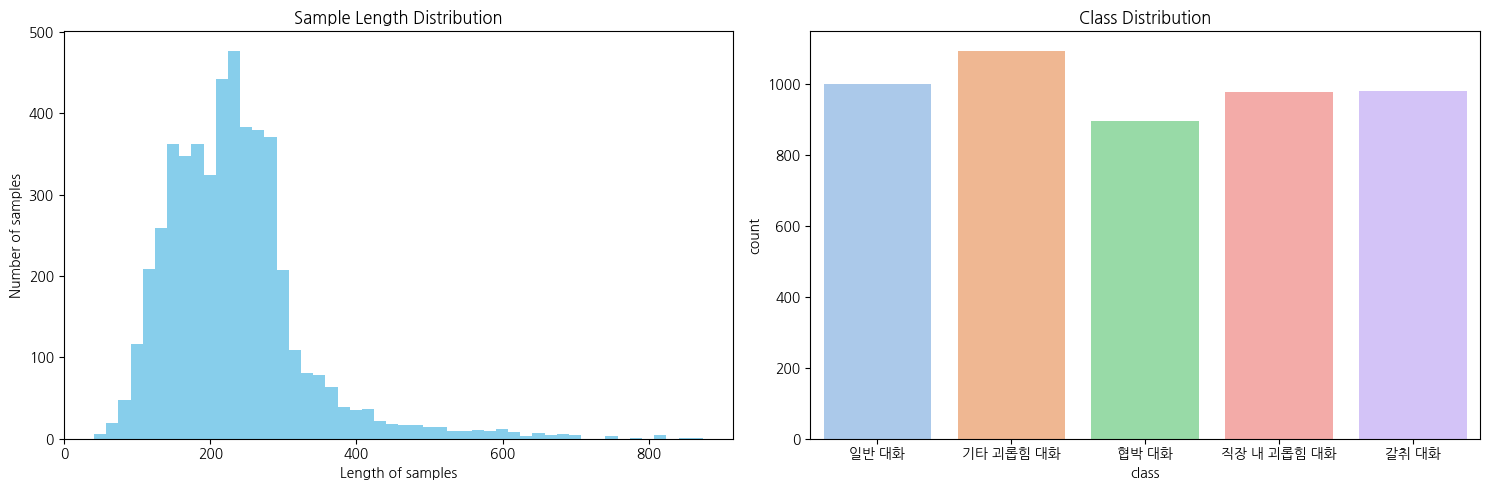

In [14]:
# 두 서브플롯 생성하기
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# 샘플 길이의 히스토그램
axes[0].hist([len(s) for s in train_data['conversation']], bins=50, color='skyblue')
axes[0].set_xlabel('Length of samples')
axes[0].set_ylabel('Number of samples')
axes[0].set_title('Sample Length Distribution')

# 클래스별 샘플 수 플롯
sns.countplot(x=train_data['class'], ax=axes[1], palette='pastel')
axes[1].set_title('Class Distribution')

# 레이아웃 조정하기
plt.tight_layout()

# 플롯 표시하기
plt.show()

클래스 별 길이 분포 확인하기

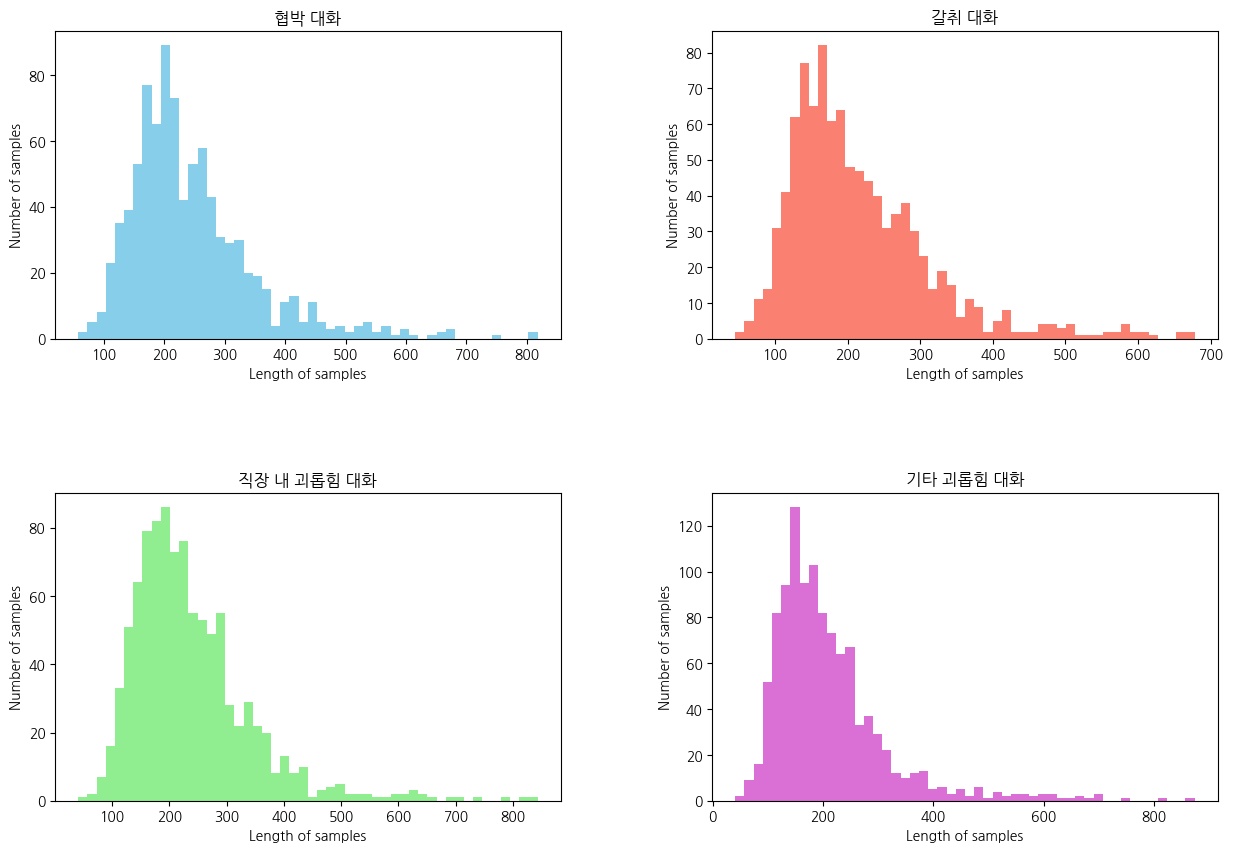

In [15]:
# 서브플롯 생성하기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# 샘플 길이의 히스토그램 그리기

# 협박 대화
axes[0][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='협박 대화']],
                bins=50, color='skyblue')
axes[0][0].set_xlabel('Length of samples')
axes[0][0].set_ylabel('Number of samples')
axes[0][0].set_title('협박 대화')

# 갈취 대화
axes[0][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='갈취 대화']],
                bins=50, color='salmon')
axes[0][1].set_xlabel('Length of samples')
axes[0][1].set_ylabel('Number of samples')
axes[0][1].set_title('갈취 대화')

# 직장 내 괴롭힘 대화
axes[1][0].hist([len(s) for s in train_data['conversation'][train_data['class']=='직장 내 괴롭힘 대화']],
                bins=50, color='lightgreen')
axes[1][0].set_xlabel('Length of samples')
axes[1][0].set_ylabel('Number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

# 기타 괴롭힘 대화
axes[1][1].hist([len(s) for s in train_data['conversation'][train_data['class']=='기타 괴롭힘 대화']],
                bins=50, color='orchid')
axes[1][1].set_xlabel('Length of samples')
axes[1][1].set_ylabel('Number of samples')
axes[1][1].set_title('기타 괴롭힘 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### **단어 기준 분석하기**

In [17]:
# 대화 추출하기
conversations = train_data['conversation'].astype(str).tolist()

In [18]:
# Okt 토크나이저 초기화
okt = Okt()

토큰 개수 확인하기

In [46]:
# 각 대화에서 토큰의 개수를 세는 함수 정의하기
def count_tokens(conversations):
    token_counts = []
    for conversation in conversations:
        tokens = okt.morphs(conversation)
        token_counts.append(len(tokens))
    return token_counts

In [47]:
# 토큰 개수 계산하기
token_counts = count_tokens(conversations)   # 시간 오래 걸림.

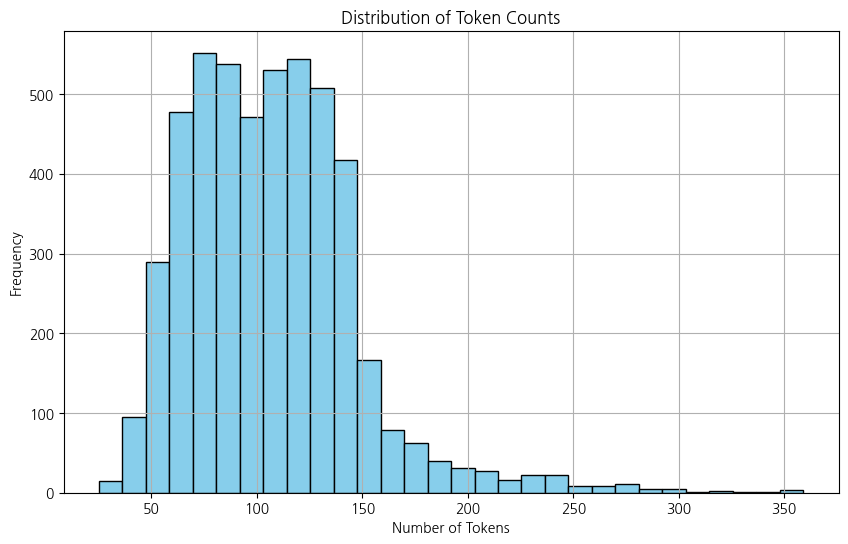

In [48]:
# 토큰 개수의 분포 시각화하기
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

명사, 형태소 추출하고, 시각화하는 함수 정의하기

In [19]:
# 명사와 형태소를 추출하는 함수 정의하기
def extract_nouns_and_morphemes(conversations):
    all_nouns = []
    all_morphemes = []
    for conversation in conversations:
        nouns = okt.nouns(conversation)
        morphemes = okt.morphs(conversation)
        all_nouns.extend(nouns)
        all_morphemes.extend(morphemes)
    return all_nouns, all_morphemes

In [20]:
# 명사와 형태소 추출하기
nouns, morphemes = extract_nouns_and_morphemes(conversations)

# 가장 흔한 명사와 형태소를 세어보기
nouns_counter = Counter(nouns)
morphemes_counter = Counter(morphemes)

# 가장 흔한 명사와 형태소 10개를 가져오기
common_nouns = nouns_counter.most_common(10)
common_morphemes = morphemes_counter.most_common(10)

In [21]:
# 시각화를 위한 데이터 준비
nouns_labels, nouns_values = zip(*common_nouns)
morphemes_labels, morphemes_values = zip(*common_morphemes)

<ipython-input-22-65ad280e2899>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(nouns_labels, rotation=45)
<ipython-input-22-65ad280e2899>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(morphemes_labels, rotation=45)


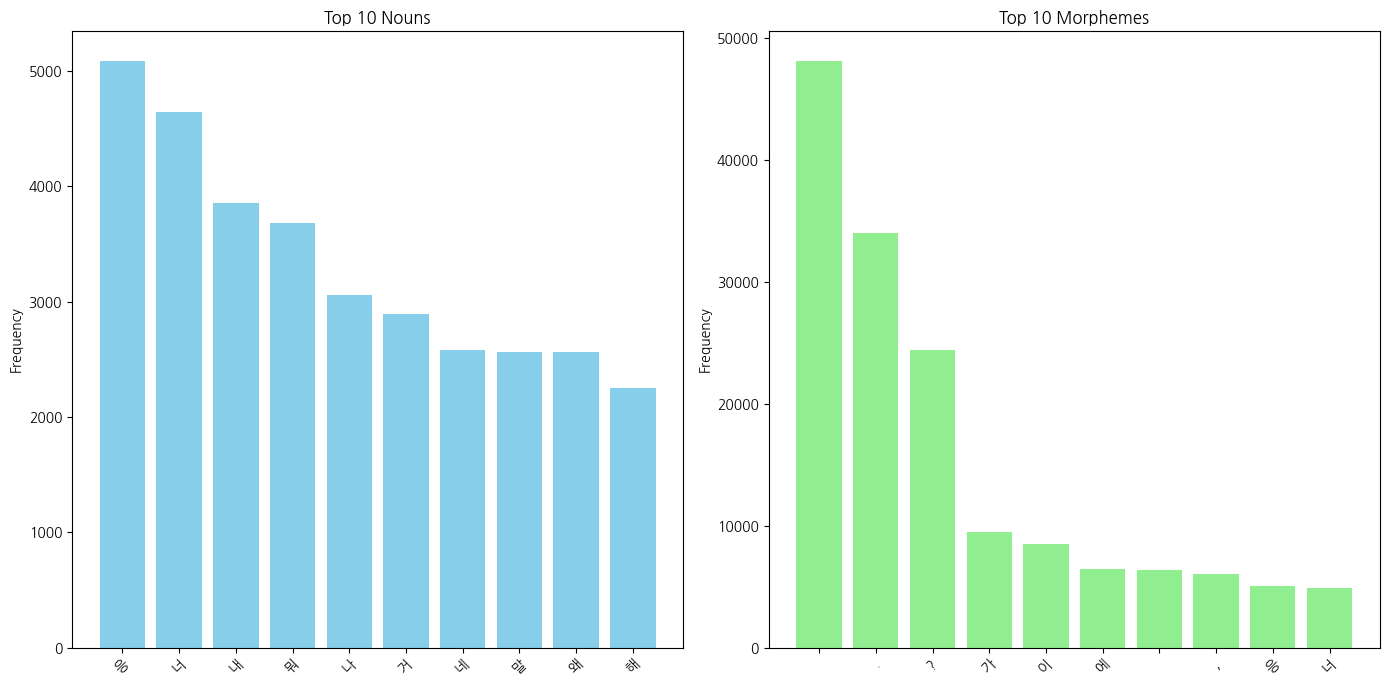

In [22]:
# 시각화하기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# 흔한 명사 시각화하기
ax1.bar(nouns_labels, nouns_values, color='skyblue')
ax1.set_title('Top 10 Nouns')  # 상위 10개 명사
ax1.set_ylabel('Frequency')  # 빈도
ax1.set_xticklabels(nouns_labels, rotation=45)

# 흔한 형태소 시각화하기
ax2.bar(morphemes_labels, morphemes_values, color='lightgreen')
ax2.set_title('Top 10 Morphemes')  # 상위 10개 형태소
ax2.set_ylabel('Frequency')  # 빈도
ax2.set_xticklabels(morphemes_labels, rotation=45)

plt.tight_layout()
plt.show()

### **대화 별로 사용한 단어 비교해보기**

대화 별로 명사, 형태소를 가장 많이 사용한 순으로 10개를 추출하고 이를 시각화하기

In [25]:
# 대화별로 상위 10개의 명사와 형태소를 추출하는 함수
def extract_top_nouns_and_morphemes(conversation):
    nouns, morphemes = extract_nouns_and_morphemes([conversation])
    noun_counter = Counter(nouns)
    morpheme_counter = Counter(morphemes)
    top_nouns = noun_counter.most_common(10)
    top_morphemes = morpheme_counter.most_common(10)
    return top_nouns, top_morphemes

In [26]:
# 대화 유형 리스트
categories = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

<ipython-input-28-18e16c142499>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(nouns_labels, rotation=45)
<ipython-input-28-18e16c142499>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(morphemes_labels, rotation=45)
<ipython-input-28-18e16c142499>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(nouns_labels, rotation=45)
<ipython-input-28-18e16c142499>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(morphemes_labels, rotation=45)
<ipython-input-28-18e16c142499>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(nouns_labels, rotation=45)
<ipython-input-28-18e16c142499>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(morphemes_labels, rotation=45)
<ipython-input-28-18e16c1424

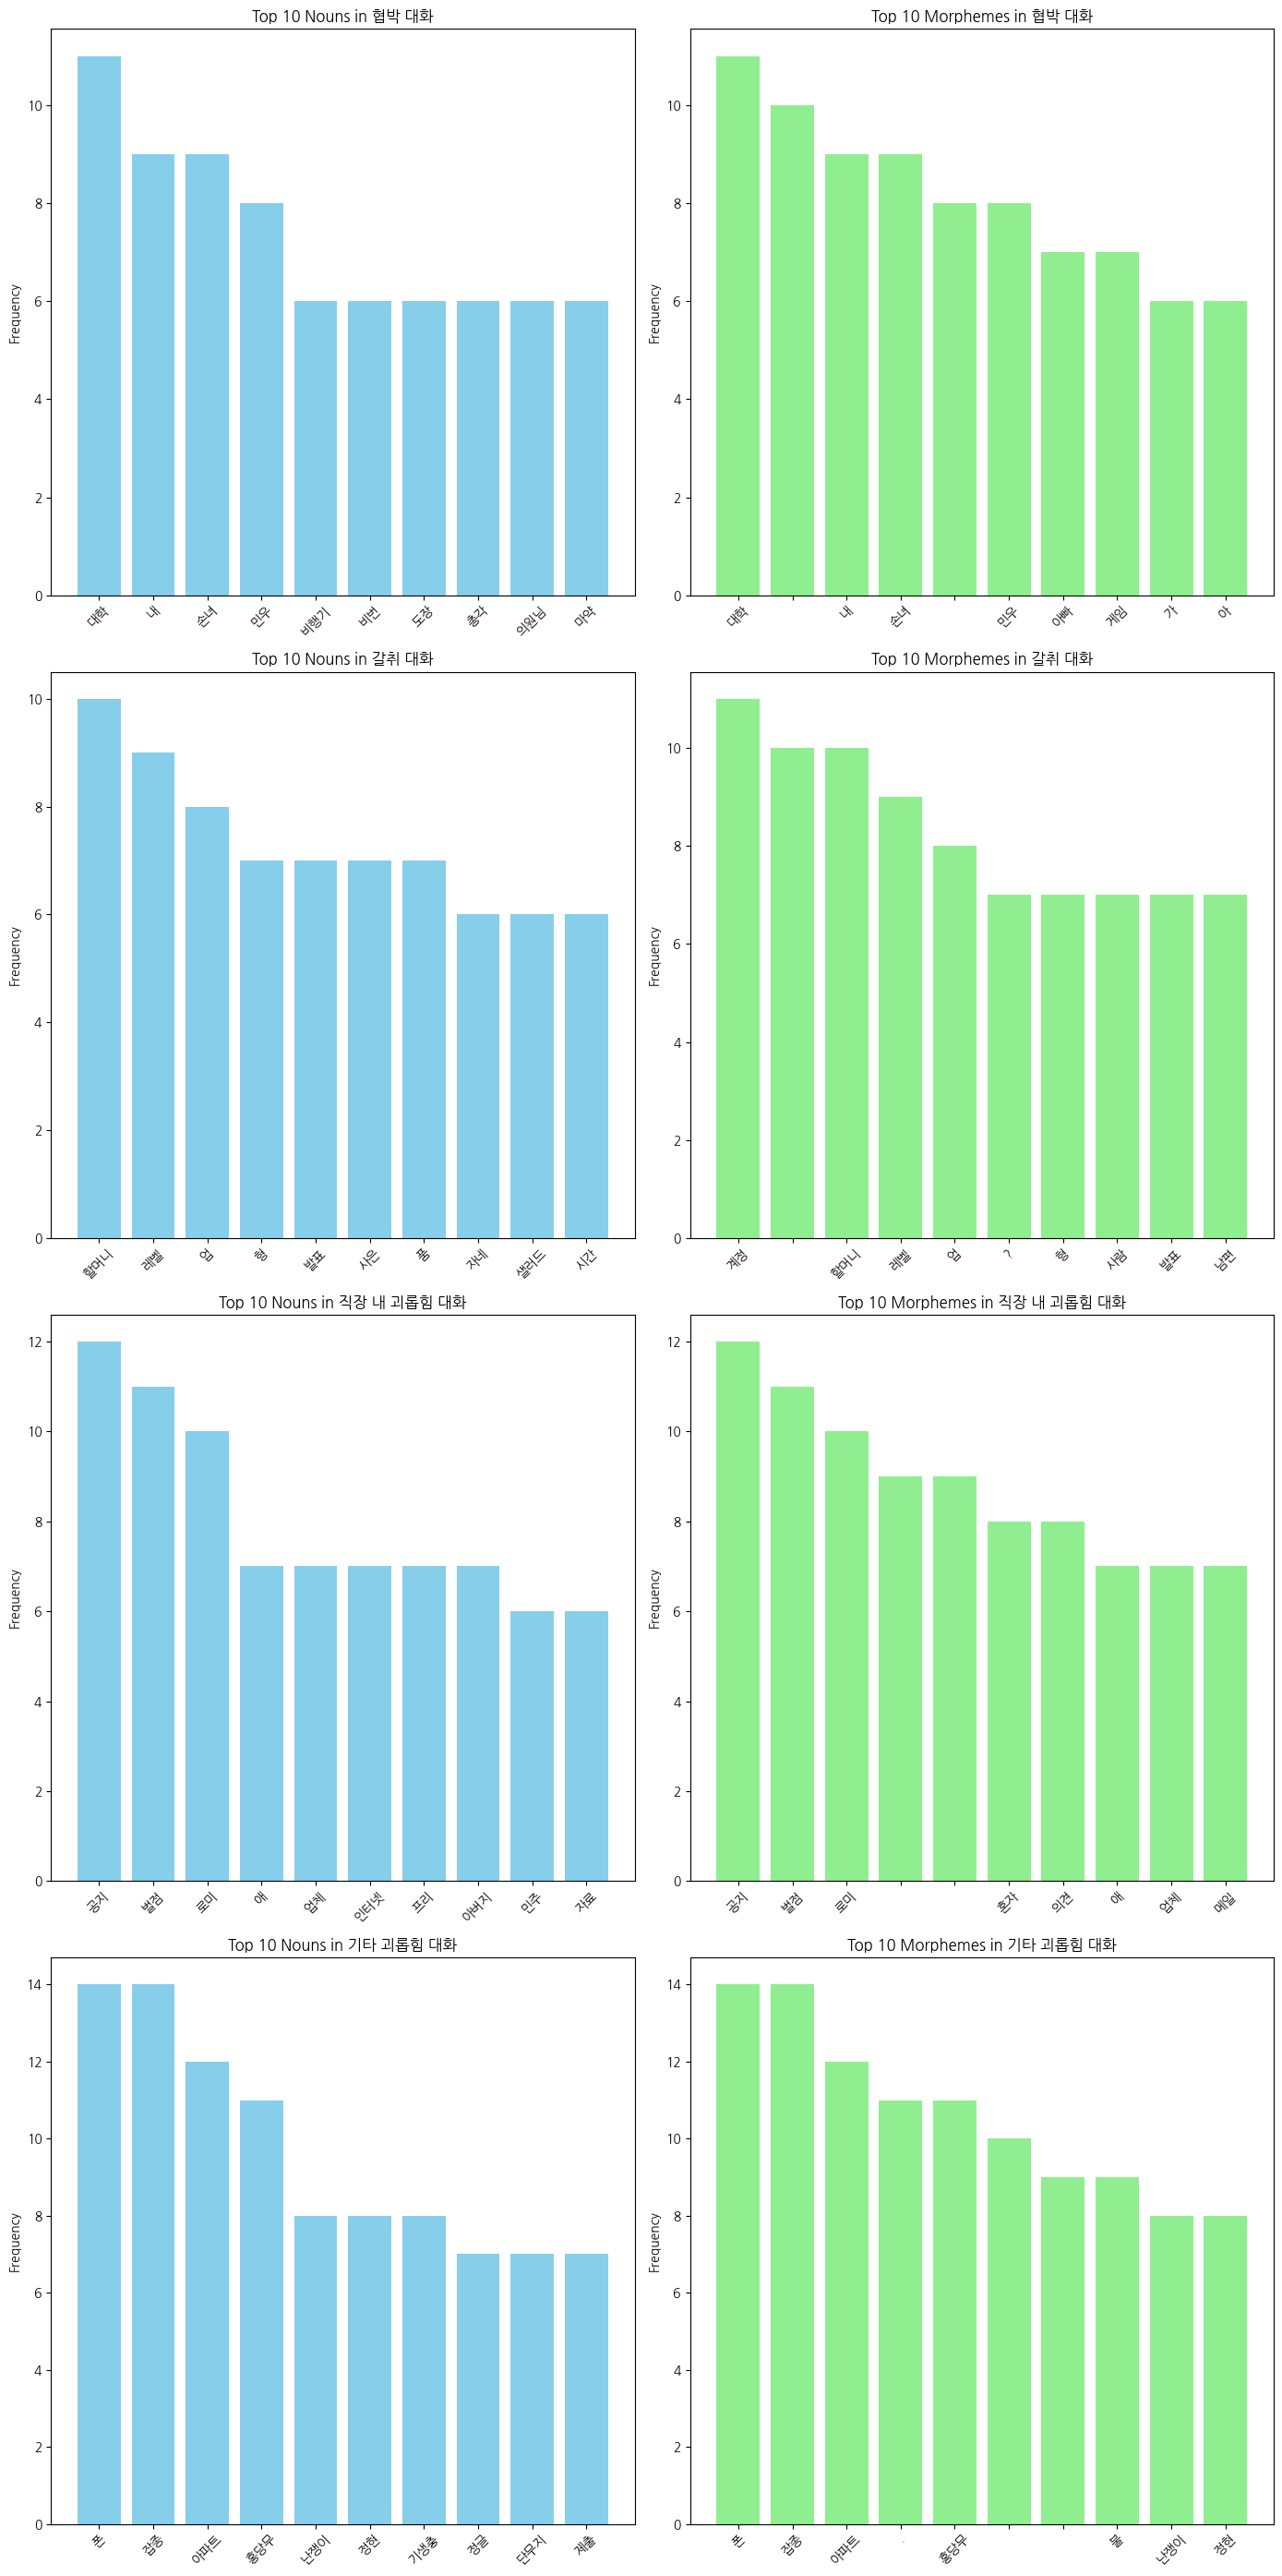

In [28]:
# 시각화하기
fig, axes = plt.subplots(len(categories), 2, figsize=(14, 7 * len(categories)))

for i, category in enumerate(categories):
    category_df = train_data[train_data['class'] == category]
    category_conversations = category_df['conversation'].astype(str).tolist()

    all_top_nouns = []
    all_top_morphemes = []

    for conversation in category_conversations:
        top_nouns, top_morphemes = extract_top_nouns_and_morphemes(conversation)
        all_top_nouns.extend(top_nouns)
        all_top_morphemes.extend(top_morphemes)

    # 명사 빈도 계산하기
    top_nouns_counter = Counter(dict(all_top_nouns))
    common_nouns = top_nouns_counter.most_common(10)
    nouns_labels, nouns_values = zip(*common_nouns) if common_nouns else ([], [])

    # 형태소 빈도 계산하기
    top_morphemes_counter = Counter(dict(all_top_morphemes))
    common_morphemes = top_morphemes_counter.most_common(10)
    morphemes_labels, morphemes_values = zip(*common_morphemes) if common_morphemes else ([], [])

    # 명사 시각화하기
    ax1 = axes[i, 0]
    ax1.bar(nouns_labels, nouns_values, color='skyblue')
    ax1.set_title(f'Top 10 Nouns in {category}')
    ax1.set_ylabel('Frequency')
    ax1.set_xticklabels(nouns_labels, rotation=45)

    # 형태소 시각화하기
    ax2 = axes[i, 1]
    ax2.bar(morphemes_labels, morphemes_values, color='lightgreen')
    ax2.set_title(f'Top 10 Morphemes in {category}')
    ax2.set_ylabel('Frequency')
    ax2.set_xticklabels(morphemes_labels, rotation=45)

plt.tight_layout()
plt.show()

### **화자 별 사용 단어 비교**

화자 A, B 두 명이라고 가정해보자.

각각 사용한 명사, 형태소 비교하기

In [29]:
# 화자별로 대화를 구분하는 함수
def separate_speakers(conversation):
    lines = conversation.split('\n')
    speaker_A = []
    speaker_B = []
    for idx, line in enumerate(lines):
        if idx % 2 == 0:
            speaker_A.append(line)
        else:
            speaker_B.append(line)
    return ' '.join(speaker_A), ' '.join(speaker_B)

In [30]:
# 모든 대화에 대해 화자별로 구분하기
speaker_A_conversations = []
speaker_B_conversations = []


for conversation in train_data['conversation'].astype(str).tolist():
    speaker_A, speaker_B = separate_speakers(conversation)
    speaker_A_conversations.append(speaker_A)
    speaker_B_conversations.append(speaker_B)

In [31]:
# 화자 A와 B의 명사와 형태소 추출하기
nouns_A, morphemes_A = extract_nouns_and_morphemes(speaker_A_conversations)
nouns_B, morphemes_B = extract_nouns_and_morphemes(speaker_B_conversations)

In [32]:
# 명사와 형태소 빈도 계산하기
nouns_A_counter = Counter(nouns_A)
morphemes_A_counter = Counter(morphemes_A)
nouns_B_counter = Counter(nouns_B)
morphemes_B_counter = Counter(morphemes_B)

In [33]:
# 상위 10개의 명사와 형태소 추출하기
common_nouns_A = nouns_A_counter.most_common(10)
common_morphemes_A = morphemes_A_counter.most_common(10)
common_nouns_B = nouns_B_counter.most_common(10)
common_morphemes_B = morphemes_B_counter.most_common(10)

In [34]:
# 데이터 준비하기
nouns_A_labels, nouns_A_values = zip(*common_nouns_A)
morphemes_A_labels, morphemes_A_values = zip(*common_morphemes_A)
nouns_B_labels, nouns_B_values = zip(*common_nouns_B)
morphemes_B_labels, morphemes_B_values = zip(*common_morphemes_B)

<ipython-input-37-7320858ae8f3>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_xticklabels(nouns_A_labels, rotation=45)
<ipython-input-37-7320858ae8f3>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(morphemes_A_labels, rotation=45)
<ipython-input-37-7320858ae8f3>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(nouns_B_labels, rotation=45)
<ipython-input-37-7320858ae8f3>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(morphemes_B_labels, rotation=45)


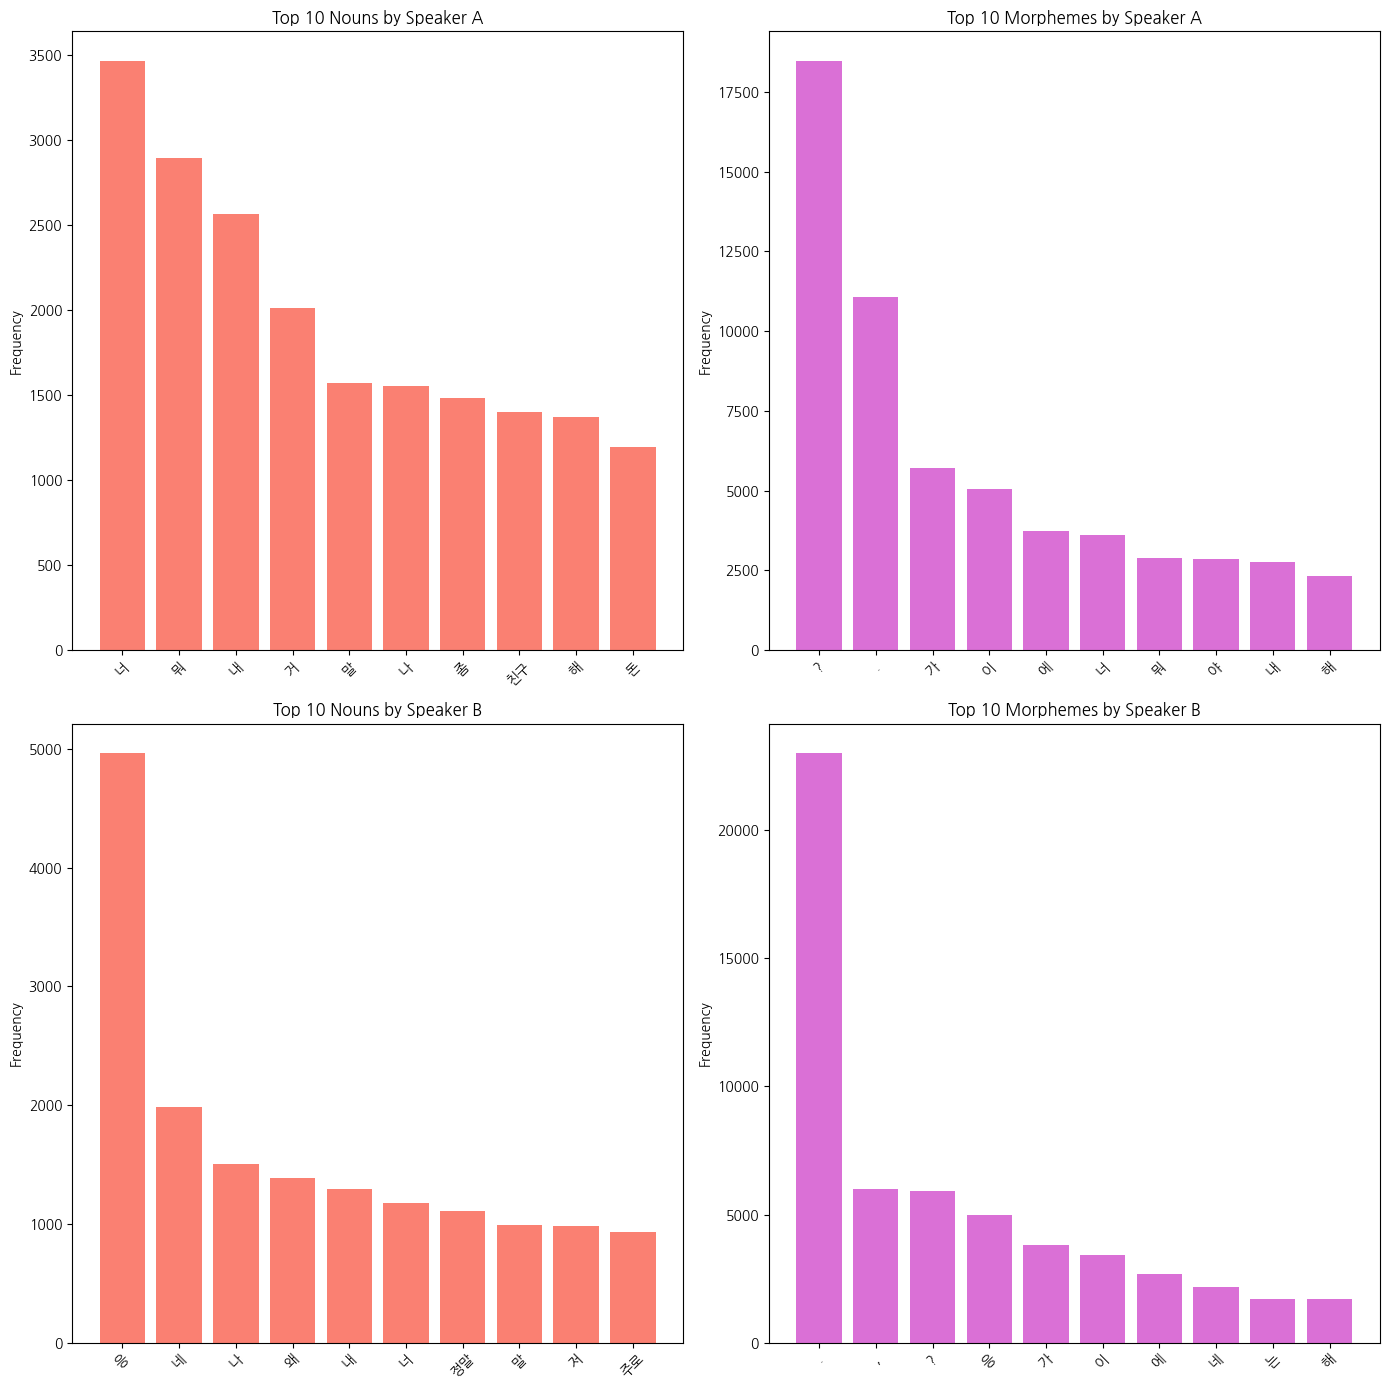

In [37]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# 화자 A의 명사 시각화하기
axes[0, 0].bar(nouns_A_labels, nouns_A_values, color='salmon')
axes[0, 0].set_title('Top 10 Nouns by Speaker A')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xticklabels(nouns_A_labels, rotation=45)

# 화자 A의 형태소 시각화하기
axes[0, 1].bar(morphemes_A_labels, morphemes_A_values, color='orchid')
axes[0, 1].set_title('Top 10 Morphemes by Speaker A')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xticklabels(morphemes_A_labels, rotation=45)

# 화자 B의 명사 시각화하기
axes[1, 0].bar(nouns_B_labels, nouns_B_values, color='salmon')
axes[1, 0].set_title('Top 10 Nouns by Speaker B')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xticklabels(nouns_B_labels, rotation=45)

# 화자 B의 형태소 시각화하기
axes[1, 1].bar(morphemes_B_labels, morphemes_B_values, color='orchid')
axes[1, 1].set_title('Top 10 Morphemes by Speaker B')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xticklabels(morphemes_B_labels, rotation=45)

plt.tight_layout()
plt.show()

중복값 여부 살펴보기

In [38]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


결측치 여부 확인하기

In [39]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

클래스 컬럼 인코딩하기

* 0(협박 대화)
* 1(갈취 대화)
* 2(직장 내 괴롭힘 대화)
* 3(기타 괴롭힘 대화)
* 4(일반 대화)

In [40]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [41]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [42]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [43]:
# idx, class 컬럼 삭제 전 데이터 복사하기
idx_class_train_data = train_data.copy()

In [44]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop('idx', axis=1)
new_train_data = new_train_data.drop('class', axis=1)

In [45]:
# new_train_dat 살펴보기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


### **분석 결과 바탕으로 불용어 리스트 생성하기**

기존 불용어 리스트 불러오기

In [49]:
# # 불용어 리스트 불러오기
origin_stopwords_path = "/content/drive/MyDrive/07. GoData/20. DKTC/ko_stopwords.txt"  # 경로 수정해주세요.
with open(origin_stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

In [51]:
# 불용어 리스트 확인하기
stopwords[:10]

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']